# Preparing the data

The exported E.S.R.A. data is stored under the relative path `./raw_data/`. This data is referenced in YAML files, located under `./datasets/`.These YAML files store the track title and artist, as well as the filename of the corresponding E.S.R.A. export, the length of the track and a list of segments (format m\:ss-m\:ss). This list is used to choose only certain STFT segments whilst excluding others. 

## Settings

+ **selected_dataset: str/None** – Select a dataset.yaml file by name. If set to None, all files will be iterated over.
+ **selected_features: \[str\]** – Features to be included in the aggregated data.

In [1]:
selected_dataset = None
selected_features = ['centroid', 'spread', 'skewness', 'kurtosis']
aggregation_stepsize = 5

## Importing required modules

Some of the required modules for this section don't come with the standard python installation. These need to either be installed manually or can be obtained by running `pipenv install` in the root directory of this repository. Naturally this requires a working `pipenv` installation. Remember to run jupyter from within the virtual environment if you are using `pipenv`.

In [2]:
from os import listdir
from lib.organise import SongData
import yaml
import pandas as pd
import numpy as np

## Obtain dataset YAML files

In [3]:
dataset_files = [ f for f in listdir('./datasets') if f.endswith('yaml') ]
dataset_files

['segmented_data.yaml', 'all_data.yaml']

## Parse dataset files and insert them into a dict

If `selected_dataset` isn't set to None, all but the specificed data will be discarded.

In [4]:
datasets = dict()

for fname in dataset_files:
    with open(f'./datasets/{fname}', 'r') as f:
        try:
            datasets[fname[:-5]] = yaml.safe_load(f)
        except yaml.YAMLError as exc:
            print(exc)
            
if selected_dataset != None:
    try:
        datasets = {selected_dataset: datasets[selected_dataset[:-5]]}
    except KeyError as exc:
        print(exc)
        
datasets.keys()

dict_keys(['segmented_data', 'all_data'])

## Iterate over datasets and organise it into SongData instances

This will populate `sorted_data` with key-value-pairs of the dataset.yaml filename and a `SongData` instance. All the metadata specified in the YAML file can be accessed via this instance's properties, as well as the actual E.S.R.A. data under its own `data` property. 

In [5]:
sorted_data = dict()

for dname, values in datasets.items():
    sorted_data[dname] = list()
    for song in values['data']:
        sorted_data[dname].append(SongData(song))
        
#The original ESRA data can now be accessed like this:
#sorted_data['all_data'][0].data

## Aggregate over time and filter features

This is achieved calling the `filter`and `aggregate` methods on each `SongData` instance. This modifies the data property and is hence a destructive operation. The aggregate method takes only the slices of STFT data that correspond to the segments specified in the YAML data. If the segments field was set to `null` all data is aggregated.

In [6]:
for dname, values in sorted_data.items():
    for song in values:
        song.filter(selected_features)
        song.aggregate(stepsize=aggregation_stepsize, method='mean')

## Combine each piece of aggregated data into a feature matrix

In [7]:
feature_matrices = list()
index_names = list()
for dname, values in sorted_data.items():
    feature_matrices.append([ s.data for s in values])
    index_names.append([ f'{s.performer} – {s.title}' for s in values ])

for i, fm in enumerate(feature_matrices):
    feature_matrices[i] = np.vstack(fm)

feature_dframes = [ pd.DataFrame(fm, index=im, columns=selected_features) for fm, im in zip(feature_matrices, index_names) ]
feature_dframes[0]

,centroid,spread,skewness,kurtosis
JPEGMAFIA – Free The Frail (feat. Helena Deland),1059.082823,1207.115803,4.663464,47.601658
Noname – Dibby Bop Feat. Raury & Cam O'bi,888.629933,963.644373,7.568263,202.591469
Denzel Curry – Walkin,1118.909882,1460.718621,3.871504,28.728890
Noname – Casket Pretty,845.551268,772.789501,5.248410,80.818895
Noname – Self,731.728129,810.082647,7.961078,153.699446
Noname – Blackxploitation,858.117250,1249.646840,4.857201,53.962731
JPEGMAFIA – PTSD,1631.008479,1492.877683,4.166104,64.492034
JPEGMAFIA – 1539 N. Calvert,907.774745,1005.707655,5.032749,70.445366
Run The Jewels – Close Your Eyes (And Count to F-k),1009.877600,1230.963083,3.452449,21.904215
clipping. – Story 7,1346.197860,1505.930341,2.300527,11.719781


# Training a groove SOM

Now that the data has been filtered, aggregated and prepared a self-organising map can be trained.

## Settings

In [125]:
neurons = (5, 5)
n_iter = 100000
eta = 0.3
nhr = 3

settings_str = f'{neurons[0]}x{neurons[1]}_{n_iter}_{eta}_{nhr}'

## Importing additional modules

To create a SOM and visualise the results some additional modules are required.

In [126]:
import matplotlib.pyplot as plt
from apollon.som.som import *
import apollon.som.utilities as asu
import time
from os import path, makedirs
from __future__ import print_function
from scipy import misc
from lib.format import meshData, labelTable

#import numpy as np
#import pandas as pd

## Normalize each feature matrix

In [127]:
scaled_matrices = [ (fm - fm.mean(axis=0)) / fm.std(axis=0) \
                   for fm in feature_matrices ]

## Init the SOMs and train them

In [128]:
som_list = list()

for fm in scaled_matrices:
    specific_dims = (neurons[0], neurons[1], fm.shape[1])
    som_list.append(IncrementalMap(specific_dims, n_iter, eta, nhr))

timestamp = str(int(time.time()))
    
for s, d in zip(som_list, scaled_matrices):
    print(f'Training SOM {som_list.index(s)+1} of {len(som_list)}...')
    %time s.fit(d)

Training SOM 1 of 2...
CPU times: user 2min 9s, sys: 282 ms, total: 2min 9s
Wall time: 2min 9s
Training SOM 2 of 2...
CPU times: user 2min 5s, sys: 189 ms, total: 2min 5s
Wall time: 2min 5s


## Visualize the trained networks

All graphics will be saved to `./output/UNIXTIME/SOMINDEX_SETTINGS_PLOTNAME.pdf`. If the corresponding directory doesn't exist, it will be created.

In [129]:
save_path = f'./output/{timestamp}'

if not path.exists(save_path):
    makedirs(save_path)

### Quantization error

For each iteration plot the mean error (distance) of all data points and their respective best matching units.

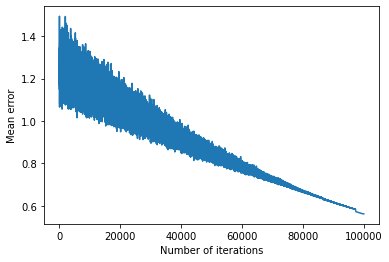

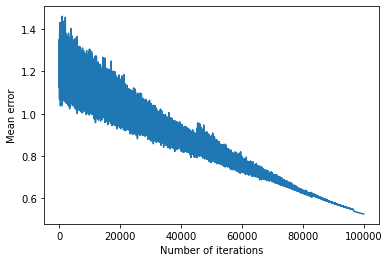

In [130]:
for s, d, i in zip(som_list, scaled_matrices, range(len(som_list))):
    fig, ax = plt.subplots(1)
    ax.set_xlabel('Number of iterations')
    ax.set_ylabel('Mean error')
    ax.plot(s.quantization_error)
    
    fig.savefig(f'{save_path}/{i+1}_{settings_str}_quantization_error.pdf')

### u-Matrix

Plots the u-Matrix for each SOM. Plots are saved alongside a matrix mesh. This is useful for visualization with pgfplots. A LaTeX table containing the lable IDs, performers, song titles, and durations is created as well. Note that this relies on a Python version of at least 3.7 as it relies on dictionaries preserving insertion order.

`lableTable` currently only escapes the control characters that appear in the provided dataset. If you need to escape additional characters you can do so by editing the `fmt` lambda function in `./lib/format.py`.

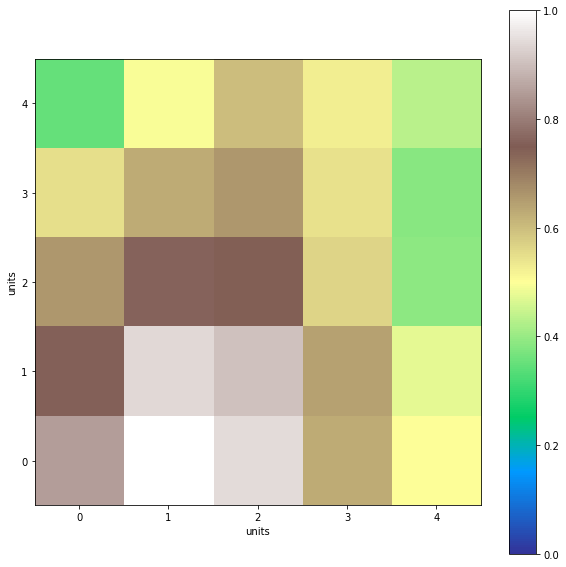

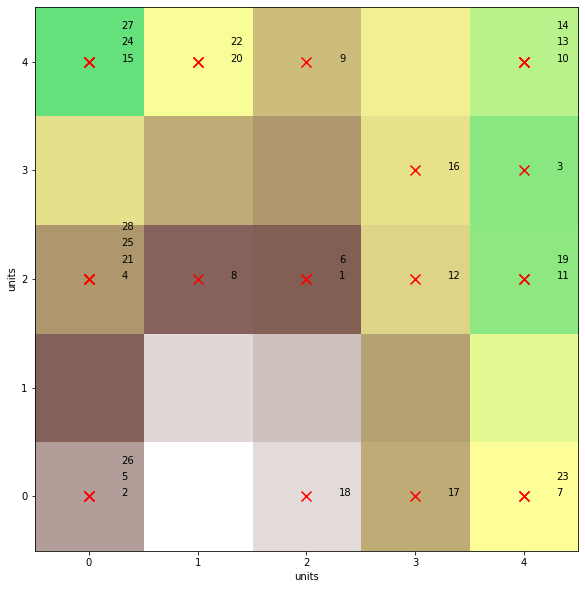

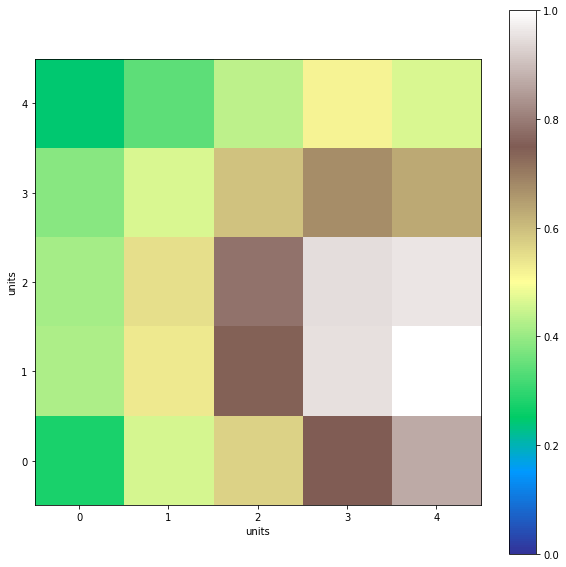

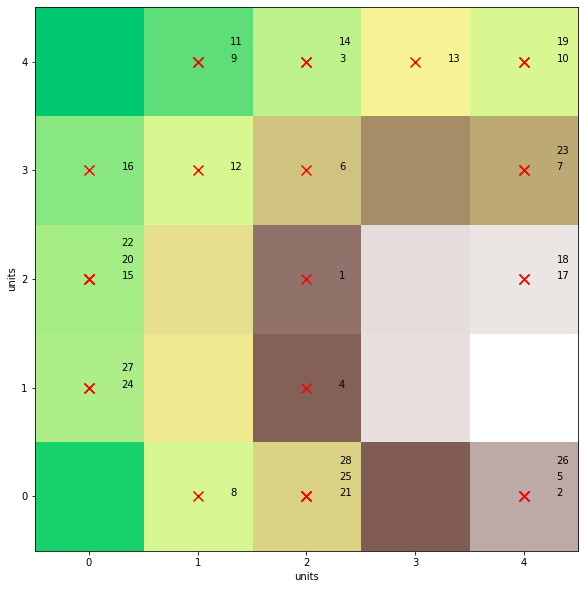

In [131]:
for s, sm, d, i in zip(som_list, scaled_matrices, sorted_data.values(), range(len(som_list))):
    um = s.umatrix()
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.set_xlabel('units')
    ax.set_ylabel('units')
    umx = ax.imshow(um, cmap='terrain', origin='lower', vmin=0, vmax=1)
    fig.colorbar(umx, ax=ax)

    fig.savefig(f'{save_path}/{i+1}_{settings_str}_umatrix.pdf')
    with open(f'{save_path}/{i+1}_{settings_str}_umatrix.dat', 'w') as f:
        f.write(meshData(um))
        
    pos, err = asu.best_match(s.weights, sm, s.metric)
    py, px = np.unravel_index(pos, s.shape)
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.set_xlabel('units')
    ax.set_ylabel('units')
    ax.imshow(um, cmap='terrain', origin='lower', vmin=0, vmax=1);
    ax.scatter(px, py, 100, 'r', 'x')
    occupied = list()
    for item, x, y in zip(range(sm.shape[0]), px, py):
        while (x,y) in occupied:
            y += 0.15
        occupied.append((x,y))
        ax.text(x+.3, y, item+1)
        
    fig.savefig(f'{saveth}/{i+1}_{settings_str}_umatrix_lables.pdf')
    with open(f'{save_path}/{i+1}_{settings_str}_lables.tex', 'w') as f:
        f.write(labelTable(d))
    
    

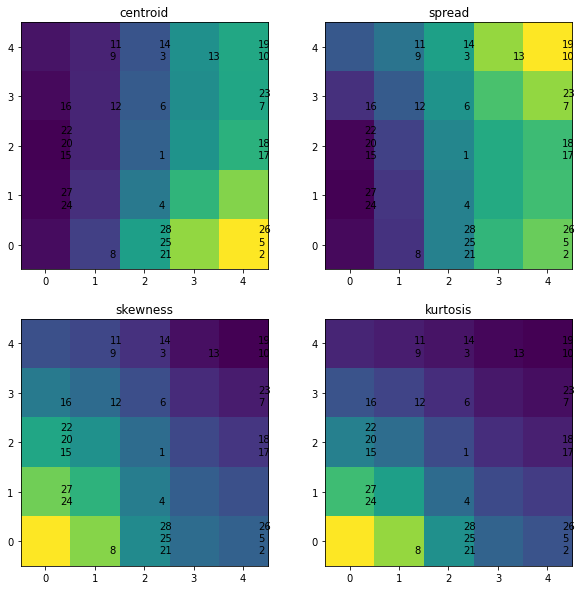

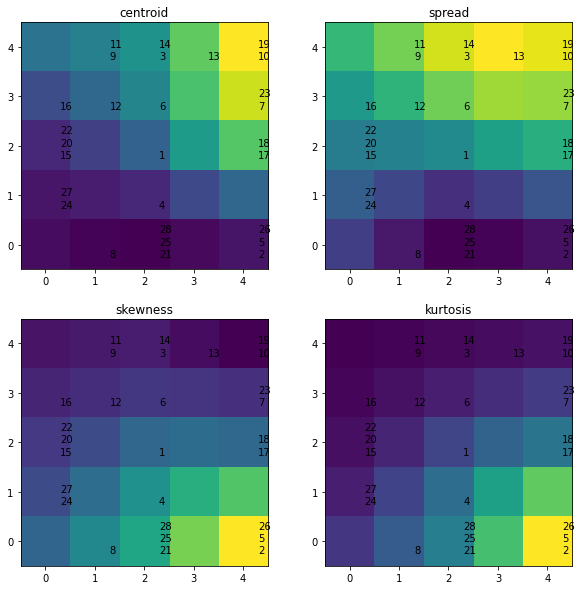

In [132]:
for s, sm, df, i in zip(som_list, scaled_matrices, feature_dframes, range(len(som_list))):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    for j, (feat, ax) in enumerate(zip(df.columns, axs.flat)):
        ax.set_title(feat)
        ax.imshow(s.weights[:, j].reshape(s.shape), origin='lower')
        occupied = list()
        for item, x, y in zip(range(sm.shape[0]), px, py):
            while (x,y) in occupied:
                y += 0.25
            occupied.append((x,y))
            ax.text(x+.3, y-0.25, item+1)
            
    fig.savefig(f'{save_path}/{i+1}_{settings_str}_features.pdf')